In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [33]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


**Convolutionl Nural Network architecture without dense connections**

---



In [34]:
# CNN architecture without dense connections
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.depthwise1 = nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32)
        self.pointwise1 = nn.Conv2d(32, 64, kernel_size=1)
        self.maxpool1 = nn.MaxPool2d(2)

        self.depthwise2 = nn.Conv2d(64, 64, kernel_size=3, padding=1, groups=64)
        self.pointwise2 = nn.Conv2d(64, 128, kernel_size=1)
        self.maxpool2 = nn.MaxPool2d(2)

        self.depthwise3 = nn.Conv2d(128, 128, kernel_size=3, padding=1, groups=128)
        self.pointwise3 = nn.Conv2d(128, 256, kernel_size=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 100)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.pointwise1(self.depthwise1(x)))
        x = self.maxpool1(x)

        x = nn.functional.relu(self.pointwise2(self.depthwise2(x)))
        x = self.maxpool2(x)

        x = nn.functional.relu(self.pointwise3(self.depthwise3(x)))
        x = self.avgpool(x)

        x = x.view(-1, 256)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [40]:
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

In [41]:
train_losses = []
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    average_loss = running_loss / len(trainloader)
    train_losses.append(average_loss)
    print(f'Epoch {epoch + 1},  Loss: {average_loss}')
    average_loss = 0.0

Epoch 1,  Loss: 4.235486529977121
Epoch 2,  Loss: 3.7439725173403846
Epoch 3,  Loss: 3.4645808843700476
Epoch 4,  Loss: 3.2431420758557135
Epoch 5,  Loss: 3.072390024009568


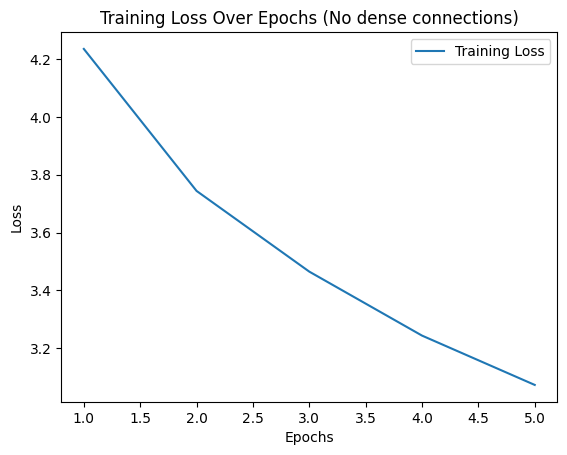

In [42]:
plt.plot(range(1, 6), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs (No dense connections)')
plt.legend()
plt.show()

Convolutionl Nural Network architecture without dense connections evaluation

In [43]:
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

In [44]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')


print("Evaluation without Dense Connections:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Evaluation without Dense Connections:
Accuracy: 0.2465
Precision: 0.25254958920237525
Recall: 0.2465
F1 Score: 0.23041120742185725


**depthwise, pointwise Convolutionl Nural Network architecture  dense connections**

[8]


In [45]:


class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = F.relu(self.depthwise(x))
        out = F.relu(self.pointwise(out))
        return out

class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels + growth_rate, growth_rate, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels + 2 * growth_rate, growth_rate, kernel_size=3, padding=1)

    def forward(self, x):
        out1 = F.relu(self.conv1(x))
        out2 = F.relu(self.conv2(torch.cat([x, out1], 1)))
        out3 = F.relu(self.conv3(torch.cat([x, out1, out2], 1)))
        return torch.cat([x, out1, out2, out3], 1)

class CNNModelwithDB(nn.Module):
    def __init__(self, growth_rate=32):
        super(CNNModelwithDB, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.depthwise1 = DepthwiseSeparableConv(32, 64)
        self.dense1 = DenseBlock(64, growth_rate)
        self.maxpool1 = nn.MaxPool2d(2)

        self.depthwise2 = DepthwiseSeparableConv(160, 256)
        self.dense2 = DenseBlock(256, growth_rate)
        self.maxpool2 = nn.MaxPool2d(2)

        self.depthwise3 = DepthwiseSeparableConv(256 + 3* growth_rate, 512)
        self.dense3 = DenseBlock(512, growth_rate)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(512 + 3* growth_rate, 256)
        self.fc2 = nn.Linear(256, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.depthwise1(x)
        x = self.dense1(x)
        x = self.maxpool1(x)

        x = self.depthwise2(x)
        x = self.dense2(x)
        x = self.maxpool2(x)

        x = self.depthwise3(x)
        x = self.dense3(x)
        x = self.avgpool(x)

        x = x.view(-1, 512 + 3 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [1]:
model = CNNModelwithDB().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5
trainwd_losses = []
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    average_loss = running_loss / len(trainloader)
    trainwd_losses.append(average_loss)
    print(f'Epoch {epoch + 1},  Loss: {average_loss}')
    average_loss  = 0.0

NameError: name 'CNNModelwithDB' is not defined

In [ ]:
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')


print("Evaluation without Dense Connections:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

depthwise, pointwise Convolutionl Nural Network architecture dense connections Evaluation

In [2]:
plt.plot(range(1, num_epochs + 1), trainwd_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs (No dense connections)')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

Comparision of the training loss

In [ ]:
plt.plot(range(1, num_epochs + 1), trainwd_losses, label='Training Loss with denseblock')
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs (No dense connections)')
plt.legend()
plt.show()